In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
# Point generation with noise
def gen_data(num_samples, noise=0):
    points = []
    labels = []

    for i in range(num_samples):
        x = np.random.uniform()
        y = np.random.uniform()

        nx = np.random.uniform(low=-noise/100, high=noise/100)
        ny = np.random.uniform(low=-noise/100, high=noise/100)

        if(-0.7*x-y+0.6 < 0 and -0.8*x-y+1.1 > 0 and 2.5*x-y > 0 and 5*x-y-3 < 0):
            if noise > 0:
                points.append([x+nx, y+ny, 0])
                labels.append(0)
            else:
                points.append([x, y, 0])
                labels.append(0)
        else:
            if noise > 0:
                points.append([x+nx, y+ny, 1])
                labels.append(1)
            else:
                points.append([x, y, 1])
                labels.append(1)

    return points, labels

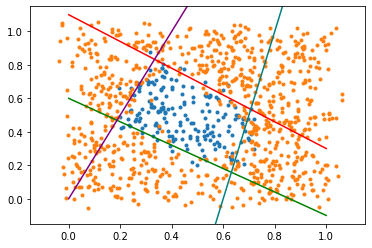

In [3]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0,1)
plt.plot(x, -(0.7*x-0.6), 'green')  # y = -0.7*x+0.6 => -0.7*x-y+0.6 >0
plt.plot(x, -(0.8*x-1.1), 'red')    # y = -0.8*x+1.1 => -0.8*x-y+1.1 < 0 
plt.plot(x, (2.5*x), 'purple')      # y = 2.5*x => 2.5*x-y < 0
plt.plot(x, (5*x-3), 'teal')        # y = 5*x-3 => 5*x-y-3 > 0

plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show()

In [4]:
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

In [5]:
# implement class wrapper for squashing activation function
class Squashing(nn.Module):
    def __init__(self, learnable=True, beta=0.1):
        '''
        Init method.
        '''
        super(Squashing, self).__init__()

        # initialize fix parameters
        self.alpha = 0.5
        self.lam = 1.0

        if learnable:
            # initialize beta as learnable parameter
            self.beta = Parameter(torch.tensor(beta))
            self.beta.requiresGrad = True
        else:
            # static value
            self.beta = torch.tensor(beta)
            self.beta.requiresGrad = False

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta 1:", self.beta.data.item())
        global betas
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )
    

In [6]:
# implement class wrapper for swish activation function
class Swish(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super(Swish, self).__init__()

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        return x * torch.sigmoid(x)

In [7]:
class Net4(nn.Module):
    def __init__(self, activation = 'squashing'):
        super(Net4,self).__init__()

        self.g1_layer = nn.Linear(in_features=2, out_features=1)
        self.g2_layer = nn.Linear(in_features=2, out_features=1)
        self.g3_layer = nn.Linear(in_features=2, out_features=1)
        self.g4_layer = nn.Linear(in_features=2, out_features=1)

        self.undgout = nn.Linear(in_features=4, out_features=1)
        
        self.undgout.bias.requires_grad  = False
        self.undgout.weight.requires_grad = False
  
        with torch.no_grad():
            self.undgout.bias.fill_(-3.0)
            self.undgout.weight.fill_(1.0)
        
        if activation == 'relu':
            print("relu")
            self.activation = nn.ReLU()
            self.activation1 = nn.ReLU()
            
        if activation == 'sigmoid':
            print("sigmoid")
            self.activation = nn.Sigmoid()
            self.activation1 = nn.Sigmoid()
            
        if activation == 'swish':
            print("swish")
            self.activation = Swish()
            self.activation1 = Swish()

        if activation == "tanh":
            print("tanh")
            self.activation = nn.Tanh()
            self.activation1 = nn.Tanh()
            
        if activation == 'squashing':
            print("squashing")
            self.activation_g1 = Squashing()
            self.activation_g2 = Squashing()
            self.activation_g3 = Squashing()
            self.activation_g4 = Squashing()
            self.activation_and = Squashing()
            
        if (activation == 'squashing-nl'):
            print("squashing-nl")
            self.activation = Squashing(False, beta=1)
            self.activation1 = Squashing(False, beta=-1)
        
        
    #This must be implemented
    def forward(self, x):
        global beta_and
        global beta_g1
        global beta_g2
        global beta_g3
        global beta_g4
        
        g1 = self.g1_layer(x)
        g1 = self.activation_g1(g1)
        beta_g1 = betas

        g2 = self.g2_layer(x)
        g2 = self.activation_g2(g2)
        beta_g2 = betas
        
        g3 = self.g3_layer(x)
        g3 = self.activation_g3(g3)
        beta_g3 = betas

        g4 = self.g4_layer(x)
        g4 = self.activation_g4(g4)
        beta_g4 = betas

        z = self.undgout(torch.cat((g1,g2,g3,g4), 1))
        z = self.activation_and(z)
        beta_and = betas

        return z


squashing
Epoch: 0
G1-Weight: tensor([[-0.3566,  0.1577]]) G1-Bias: tensor([-0.5732])
G2-Weight: tensor([[-0.1051,  0.4731]]) G2-Bias: tensor([0.3574])
G3-Weight: tensor([[0.0722, 0.0835]]) G1-Bias: tensor([-0.4847])
G4-Weight: tensor([[-0.1523,  0.5069]]) G2-Bias: tensor([0.6214])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.3566 * x + -0.5732) / 0.1577)
z2: y = -((-0.1051 * x + 0.3574) / 0.4731)
z3: y = -((0.0722 * x + -0.4847) / 0.0835)
z4: y = -((-0.1523 * x + 0.6214) / 0.5069)


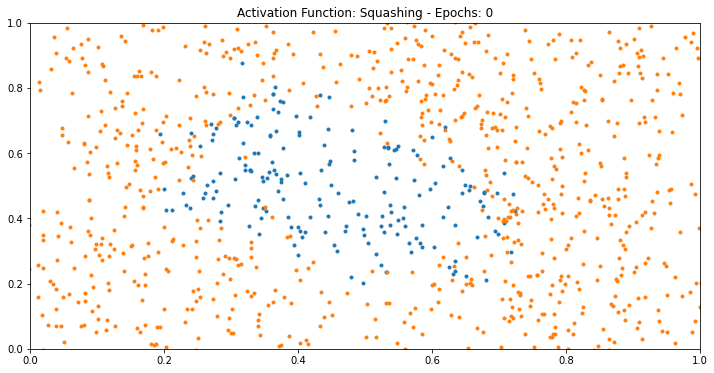

Epoch: 100
G1-Weight: tensor([[-0.9772,  0.0015]]) G1-Bias: tensor([-0.8618])
G2-Weight: tensor([[0.7926, 0.5417]]) G2-Bias: tensor([0.5742])
G3-Weight: tensor([[-0.7025, -0.0669]]) G1-Bias: tensor([-0.7769])
G4-Weight: tensor([[-0.4190,  0.4621]]) G2-Bias: tensor([0.5801])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.9772 * x + -0.8618) / 0.0015)
z2: y = -((0.7926 * x + 0.5742) / 0.5417)
z3: y = -((-0.7025 * x + -0.7769) / -0.0669)
z4: y = -((-0.419 * x + 0.5801) / 0.4621)


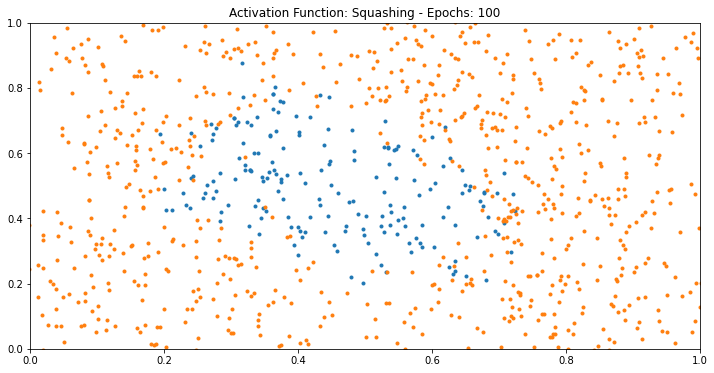

Epoch: 200
G1-Weight: tensor([[-0.9821,  0.0492]]) G1-Bias: tensor([-0.6662])
G2-Weight: tensor([[1.2591, 0.3050]]) G2-Bias: tensor([0.2350])
G3-Weight: tensor([[-0.8812, -0.0214]]) G1-Bias: tensor([-0.6153])
G4-Weight: tensor([[-1.5265,  0.4444]]) G2-Bias: tensor([1.0953])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.9821 * x + -0.6662) / 0.0492)
z2: y = -((1.2591 * x + 0.235) / 0.305)
z3: y = -((-0.8812 * x + -0.6153) / -0.0214)
z4: y = -((-1.5265 * x + 1.0953) / 0.4444)


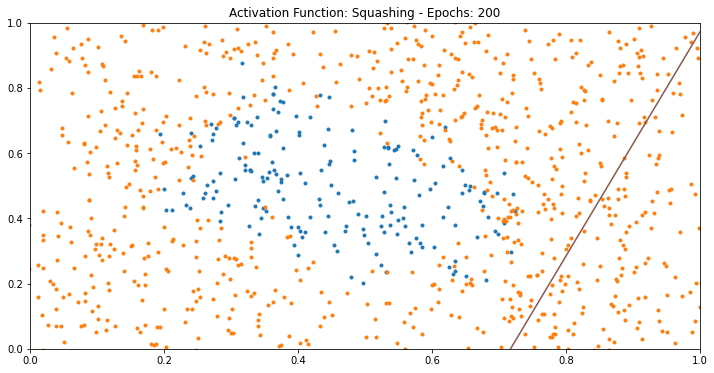

Epoch: 300
G1-Weight: tensor([[-0.0897, -0.3089]]) G1-Bias: tensor([-0.8621])
G2-Weight: tensor([[0.3299, 0.7793]]) G2-Bias: tensor([0.2843])
G3-Weight: tensor([[ 0.0064, -0.3220]]) G1-Bias: tensor([-0.8156])
G4-Weight: tensor([[-5.0229,  0.0619]]) G2-Bias: tensor([3.9401])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((-0.0897 * x + -0.8621) / -0.3089)
z2: y = -((0.3299 * x + 0.2843) / 0.7793)
z3: y = -((0.0064 * x + -0.8156) / -0.322)
z4: y = -((-5.0229 * x + 3.9401) / 0.0619)


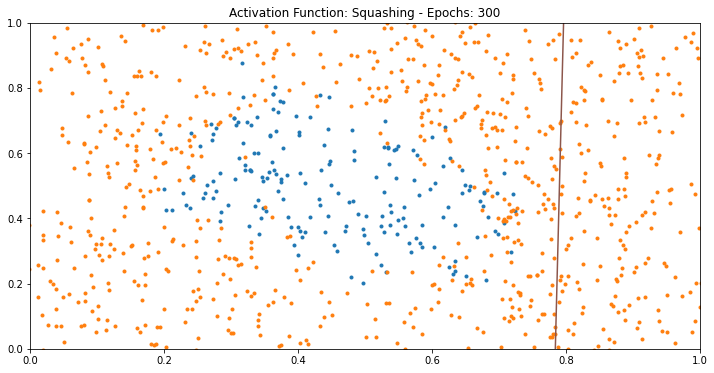

Epoch: 400
G1-Weight: tensor([[1.5218, 0.4362]]) G1-Bias: tensor([-0.5001])
G2-Weight: tensor([[1.3172, 1.4014]]) G2-Bias: tensor([0.3807])
G3-Weight: tensor([[1.9257, 0.7171]]) G1-Bias: tensor([-0.2278])
G4-Weight: tensor([[-7.0232, -2.1973]]) G2-Bias: tensor([6.1476])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.5218 * x + -0.5001) / 0.4362)
z2: y = -((1.3172 * x + 0.3807) / 1.4014)
z3: y = -((1.9257 * x + -0.2278) / 0.7171)
z4: y = -((-7.0232 * x + 6.1476) / -2.1973)


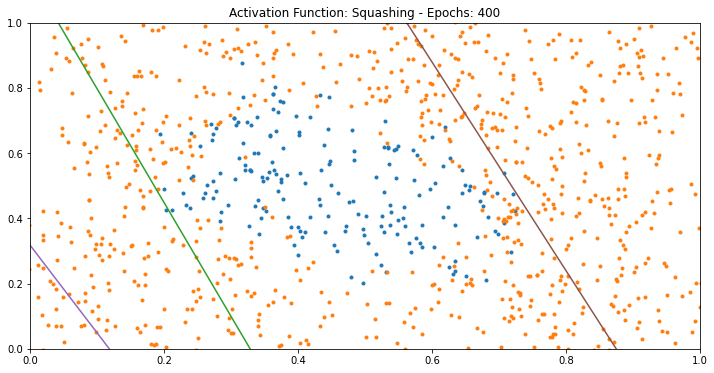

Epoch: 500
G1-Weight: tensor([[ 1.1244, -0.1514]]) G1-Bias: tensor([0.0133])
G2-Weight: tensor([[1.2947, 3.5473]]) G2-Bias: tensor([1.6966])
G3-Weight: tensor([[6.9269, 0.7677]]) G1-Bias: tensor([-1.6195])
G4-Weight: tensor([[-8.2499, -2.6696]]) G2-Bias: tensor([7.0080])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((1.1244 * x + 0.0133) / -0.1514)
z2: y = -((1.2947 * x + 1.6966) / 3.5473)
z3: y = -((6.9269 * x + -1.6195) / 0.7677)
z4: y = -((-8.2499 * x + 7.008) / -2.6696)


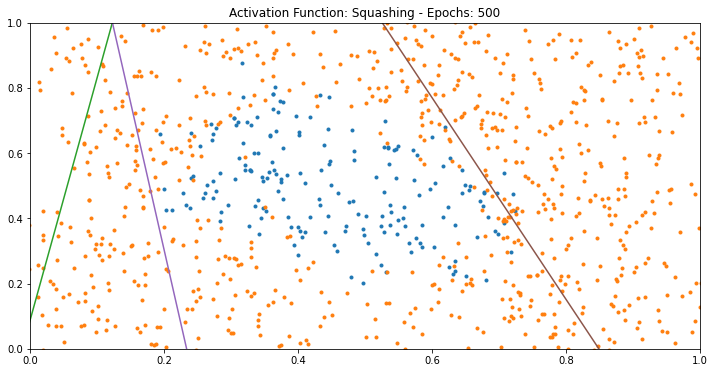

Epoch: 600
G1-Weight: tensor([[ 3.1685, -0.4942]]) G1-Bias: tensor([-1.7574])
G2-Weight: tensor([[-1.2436,  9.9750]]) G2-Bias: tensor([-1.4944])
G3-Weight: tensor([[ 8.7365, -0.4116]]) G1-Bias: tensor([-1.6445])
G4-Weight: tensor([[-6.2274, -6.6860]]) G2-Bias: tensor([8.2811])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((3.1685 * x + -1.7574) / -0.4942)
z2: y = -((-1.2436 * x + -1.4944) / 9.975)
z3: y = -((8.7365 * x + -1.6445) / -0.4116)
z4: y = -((-6.2274 * x + 8.2811) / -6.686)


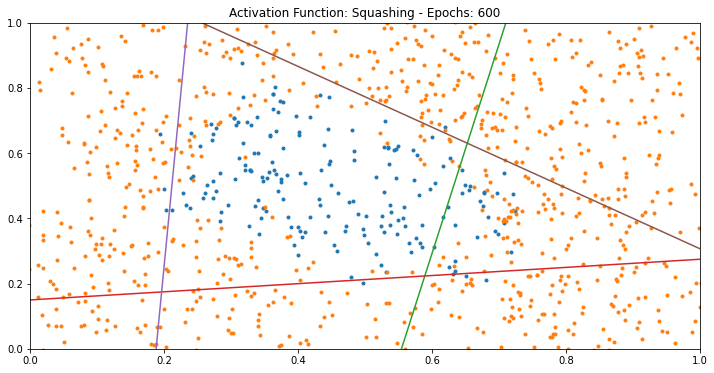

Epoch: 700
G1-Weight: tensor([[7.1912, 1.1200]]) G1-Bias: tensor([-4.8408])
G2-Weight: tensor([[ 1.4290, 11.7723]]) G2-Bias: tensor([-3.4693])
G3-Weight: tensor([[ 9.1814, -0.1583]]) G1-Bias: tensor([-1.8618])
G4-Weight: tensor([[-4.7850, -8.0263]]) G2-Bias: tensor([8.4375])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.1912 * x + -4.8408) / 1.12)
z2: y = -((1.429 * x + -3.4693) / 11.7723)
z3: y = -((9.1814 * x + -1.8618) / -0.1583)
z4: y = -((-4.785 * x + 8.4375) / -8.0263)


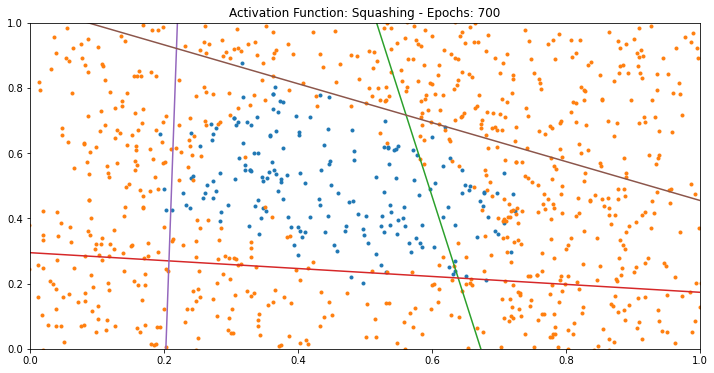

Epoch: 800
G1-Weight: tensor([[8.5116, 1.3322]]) G1-Bias: tensor([-5.8079])
G2-Weight: tensor([[ 3.0521, 12.7992]]) G2-Bias: tensor([-4.6417])
G3-Weight: tensor([[ 9.6295, -1.4154]]) G1-Bias: tensor([-1.1554])
G4-Weight: tensor([[-4.5701, -7.6561]]) G2-Bias: tensor([8.1198])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.5116 * x + -5.8079) / 1.3322)
z2: y = -((3.0521 * x + -4.6417) / 12.7992)
z3: y = -((9.6295 * x + -1.1554) / -1.4154)
z4: y = -((-4.5701 * x + 8.1198) / -7.6561)


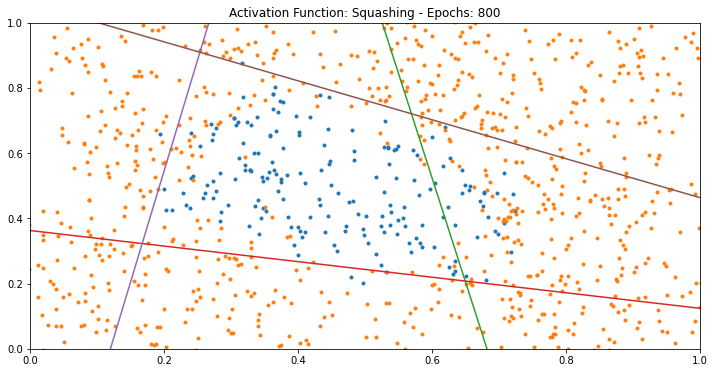

Epoch: 900
G1-Weight: tensor([[9.1879, 1.0326]]) G1-Bias: tensor([-6.1397])
G2-Weight: tensor([[ 4.4653, 13.4855]]) G2-Bias: tensor([-5.5334])
G3-Weight: tensor([[10.2462, -2.9416]]) G1-Bias: tensor([-0.3540])
G4-Weight: tensor([[-4.8582, -7.2908]]) G2-Bias: tensor([8.0422])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.1879 * x + -6.1397) / 1.0326)
z2: y = -((4.4653 * x + -5.5334) / 13.4855)
z3: y = -((10.2462 * x + -0.354) / -2.9416)
z4: y = -((-4.8582 * x + 8.0422) / -7.2908)


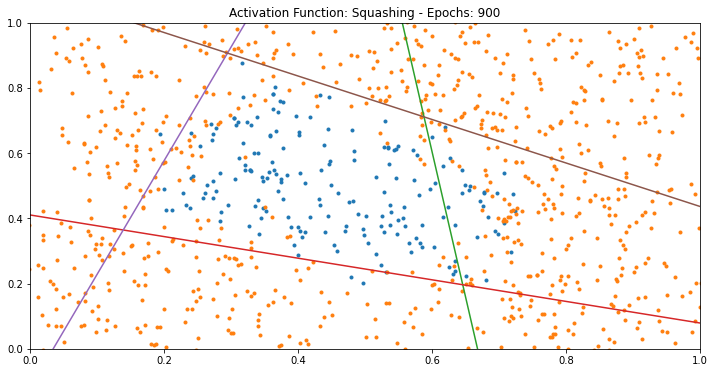

Epoch: 1000
G1-Weight: tensor([[9.5930, 0.4319]]) G1-Bias: tensor([-6.1790])
G2-Weight: tensor([[ 5.3204, 14.0640]]) G2-Bias: tensor([-6.0615])
G3-Weight: tensor([[10.4118, -3.3695]]) G1-Bias: tensor([-0.1277])
G4-Weight: tensor([[-5.2345, -7.1541]]) G2-Bias: tensor([8.1326])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.593 * x + -6.179) / 0.4319)
z2: y = -((5.3204 * x + -6.0615) / 14.064)
z3: y = -((10.4118 * x + -0.1277) / -3.3695)
z4: y = -((-5.2345 * x + 8.1326) / -7.1541)


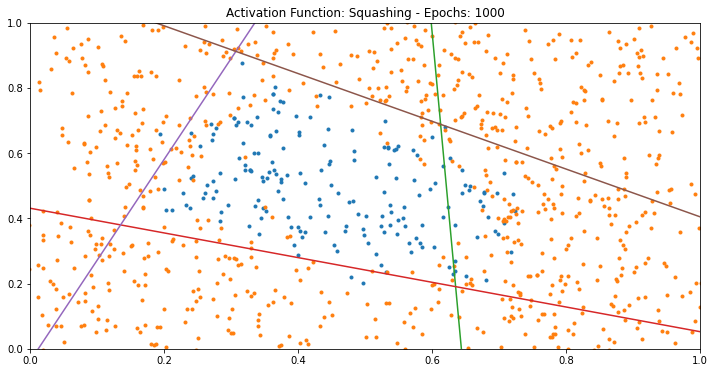

Epoch: 1100
G1-Weight: tensor([[ 9.8634, -0.2263]]) G1-Bias: tensor([-6.1142])
G2-Weight: tensor([[ 6.0231, 14.5312]]) G2-Bias: tensor([-6.4811])
G3-Weight: tensor([[10.7569, -3.7757]]) G1-Bias: tensor([0.0316])
G4-Weight: tensor([[-5.7160, -7.0245]]) G2-Bias: tensor([8.2829])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.8634 * x + -6.1142) / -0.2263)
z2: y = -((6.0231 * x + -6.4811) / 14.5312)
z3: y = -((10.7569 * x + 0.0316) / -3.7757)
z4: y = -((-5.716 * x + 8.2829) / -7.0245)


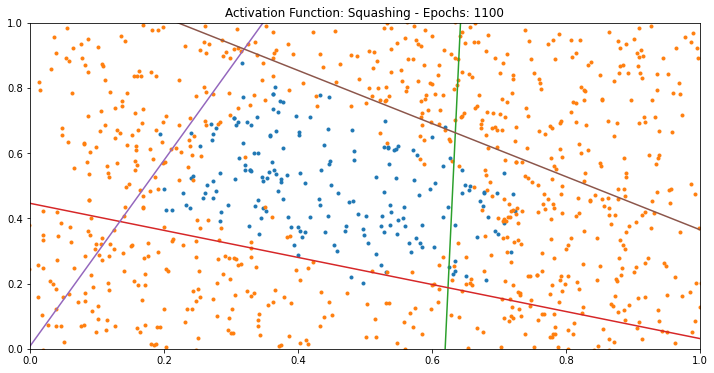

Epoch: 1200
G1-Weight: tensor([[ 9.9564, -0.7346]]) G1-Bias: tensor([-5.9829])
G2-Weight: tensor([[ 6.6108, 14.9482]]) G2-Bias: tensor([-6.8364])
G3-Weight: tensor([[11.1665, -4.1307]]) G1-Bias: tensor([0.1451])
G4-Weight: tensor([[-6.0433, -7.0378]]) G2-Bias: tensor([8.4574])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.9564 * x + -5.9829) / -0.7346)
z2: y = -((6.6108 * x + -6.8364) / 14.9482)
z3: y = -((11.1665 * x + 0.1451) / -4.1307)
z4: y = -((-6.0433 * x + 8.4574) / -7.0378)


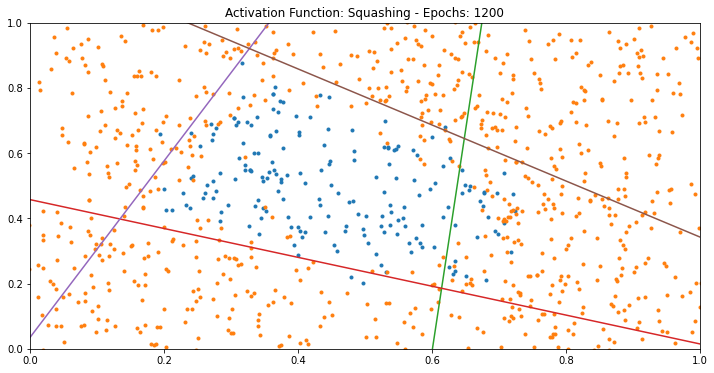

Epoch: 1300
G1-Weight: tensor([[ 9.9368, -1.5190]]) G1-Bias: tensor([-5.6689])
G2-Weight: tensor([[ 7.2489, 15.3081]]) G2-Bias: tensor([-7.1758])
G3-Weight: tensor([[11.5859, -4.4248]]) G1-Bias: tensor([0.2202])
G4-Weight: tensor([[-6.3637, -7.1080]]) G2-Bias: tensor([8.6605])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.9368 * x + -5.6689) / -1.519)
z2: y = -((7.2489 * x + -7.1758) / 15.3081)
z3: y = -((11.5859 * x + 0.2202) / -4.4248)
z4: y = -((-6.3637 * x + 8.6605) / -7.108)


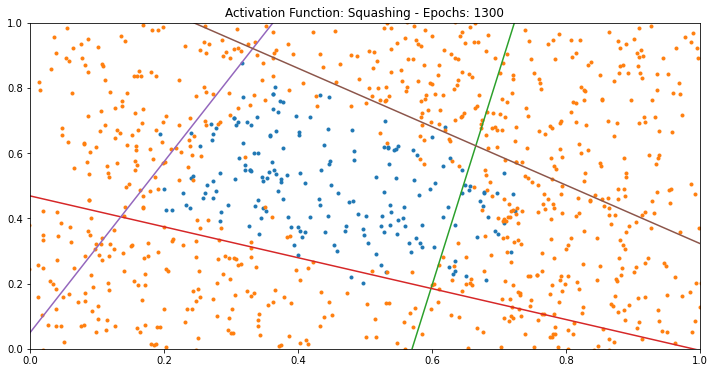

Epoch: 1400
G1-Weight: tensor([[ 9.7771, -2.1359]]) G1-Bias: tensor([-5.3273])
G2-Weight: tensor([[ 7.8560, 15.6550]]) G2-Bias: tensor([-7.5046])
G3-Weight: tensor([[12.0037, -4.7398]]) G1-Bias: tensor([0.3077])
G4-Weight: tensor([[-6.6845, -7.2078]]) G2-Bias: tensor([8.8889])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.7771 * x + -5.3273) / -2.1359)
z2: y = -((7.856 * x + -7.5046) / 15.655)
z3: y = -((12.0037 * x + 0.3077) / -4.7398)
z4: y = -((-6.6845 * x + 8.8889) / -7.2078)


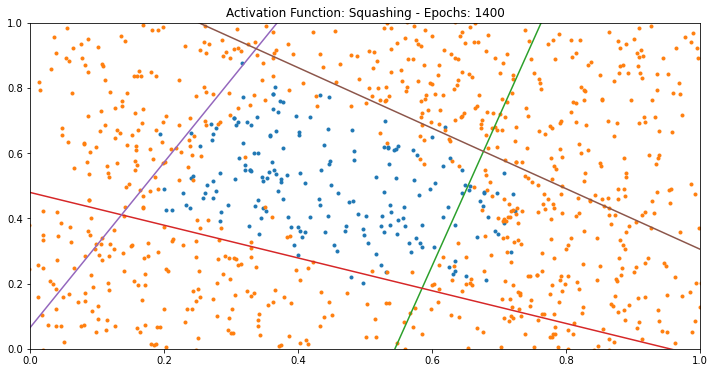

Epoch: 1500
G1-Weight: tensor([[ 9.5500, -2.3033]]) G1-Bias: tensor([-5.1081])
G2-Weight: tensor([[ 8.2077, 16.0384]]) G2-Bias: tensor([-7.7602])
G3-Weight: tensor([[12.4340, -4.9726]]) G1-Bias: tensor([0.3415])
G4-Weight: tensor([[-6.8762, -7.3595]]) G2-Bias: tensor([9.0933])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.55 * x + -5.1081) / -2.3033)
z2: y = -((8.2077 * x + -7.7602) / 16.0384)
z3: y = -((12.434 * x + 0.3415) / -4.9726)
z4: y = -((-6.8762 * x + 9.0933) / -7.3595)


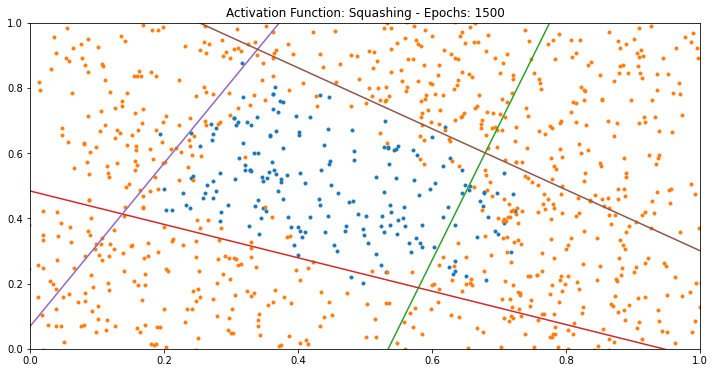

Epoch: 1600
G1-Weight: tensor([[ 9.3660, -2.3989]]) G1-Bias: tensor([-4.9484])
G2-Weight: tensor([[ 8.4859, 16.4014]]) G2-Bias: tensor([-7.9823])
G3-Weight: tensor([[12.8613, -5.1840]]) G1-Bias: tensor([0.3605])
G4-Weight: tensor([[-7.0326, -7.5032]]) G2-Bias: tensor([9.2703])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.366 * x + -4.9484) / -2.3989)
z2: y = -((8.4859 * x + -7.9823) / 16.4014)
z3: y = -((12.8613 * x + 0.3605) / -5.184)
z4: y = -((-7.0326 * x + 9.2703) / -7.5032)


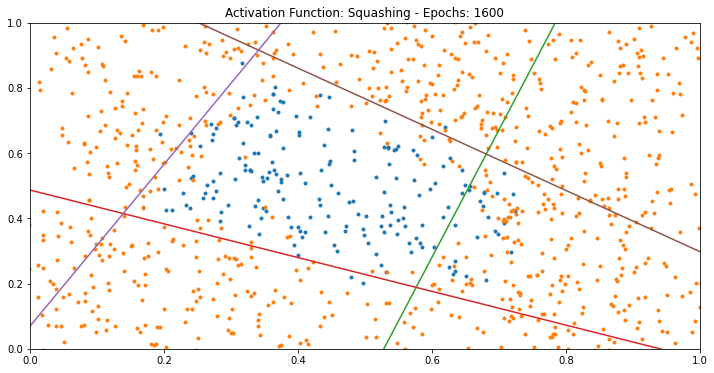

Epoch: 1700
G1-Weight: tensor([[ 9.2302, -2.4702]]) G1-Bias: tensor([-4.8293])
G2-Weight: tensor([[ 8.7238, 16.7394]]) G2-Bias: tensor([-8.1823])
G3-Weight: tensor([[13.2796, -5.3824]]) G1-Bias: tensor([0.3747])
G4-Weight: tensor([[-7.1648, -7.6257]]) G2-Bias: tensor([9.4212])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.2302 * x + -4.8293) / -2.4702)
z2: y = -((8.7238 * x + -8.1823) / 16.7394)
z3: y = -((13.2796 * x + 0.3747) / -5.3824)
z4: y = -((-7.1648 * x + 9.4212) / -7.6257)


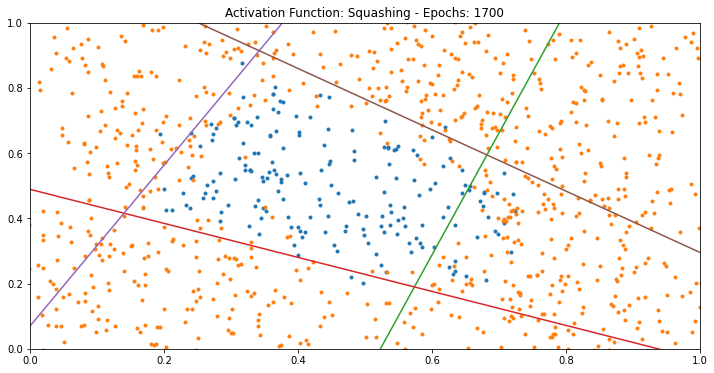

Epoch: 1800
G1-Weight: tensor([[ 9.1275, -2.5032]]) G1-Bias: tensor([-4.7500])
G2-Weight: tensor([[ 8.8531, 16.9277]]) G2-Bias: tensor([-8.2928])
G3-Weight: tensor([[13.6843, -5.5710]]) G1-Bias: tensor([0.3890])
G4-Weight: tensor([[-7.2762, -7.7321]]) G2-Bias: tensor([9.5520])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.1275 * x + -4.75) / -2.5032)
z2: y = -((8.8531 * x + -8.2928) / 16.9277)
z3: y = -((13.6843 * x + 0.389) / -5.571)
z4: y = -((-7.2762 * x + 9.552) / -7.7321)


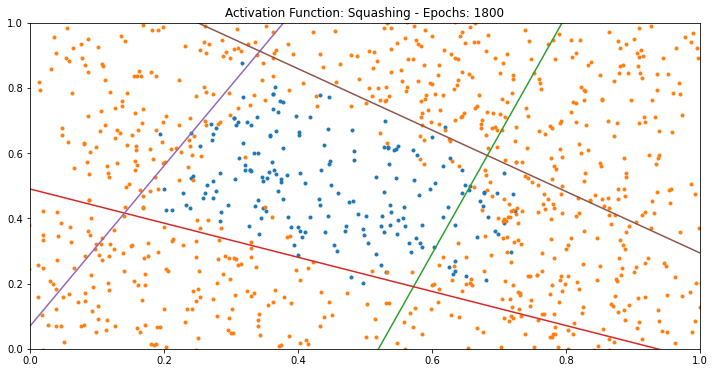

Epoch: 1900
G1-Weight: tensor([[ 9.0487, -2.5423]]) G1-Bias: tensor([-4.6817])
G2-Weight: tensor([[ 8.9167, 16.9517]]) G2-Bias: tensor([-8.3238])
G3-Weight: tensor([[14.0801, -5.7628]]) G1-Bias: tensor([0.4041])
G4-Weight: tensor([[-7.3720, -7.8230]]) G2-Bias: tensor([9.6605])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((9.0487 * x + -4.6817) / -2.5423)
z2: y = -((8.9167 * x + -8.3238) / 16.9517)
z3: y = -((14.0801 * x + 0.4041) / -5.7628)
z4: y = -((-7.372 * x + 9.6605) / -7.823)


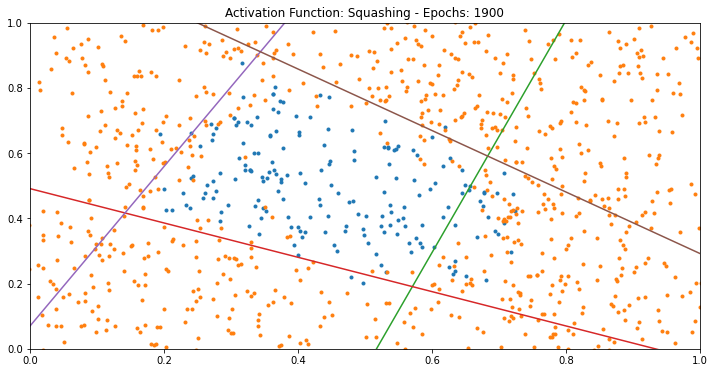

Epoch: 2000
G1-Weight: tensor([[ 8.9735, -2.5780]]) G1-Bias: tensor([-4.6191])
G2-Weight: tensor([[ 8.9764, 16.9787]]) G2-Bias: tensor([-8.3516])
G3-Weight: tensor([[14.4652, -5.9450]]) G1-Bias: tensor([0.4208])
G4-Weight: tensor([[-7.4539, -7.8965]]) G2-Bias: tensor([9.7555])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.9735 * x + -4.6191) / -2.578)
z2: y = -((8.9764 * x + -8.3516) / 16.9787)
z3: y = -((14.4652 * x + 0.4208) / -5.945)
z4: y = -((-7.4539 * x + 9.7555) / -7.8965)


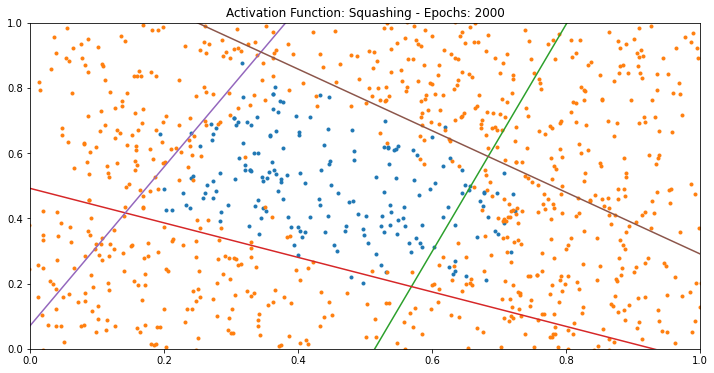

Epoch: 2100
G1-Weight: tensor([[ 8.9010, -2.6065]]) G1-Bias: tensor([-4.5598])
G2-Weight: tensor([[ 9.0319, 17.0080]]) G2-Bias: tensor([-8.3796])
G3-Weight: tensor([[14.8404, -6.1260]]) G1-Bias: tensor([0.4322])
G4-Weight: tensor([[-7.5250, -7.9608]]) G2-Bias: tensor([9.8334])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.901 * x + -4.5598) / -2.6065)
z2: y = -((9.0319 * x + -8.3796) / 17.008)
z3: y = -((14.8404 * x + 0.4322) / -6.126)
z4: y = -((-7.525 * x + 9.8334) / -7.9608)


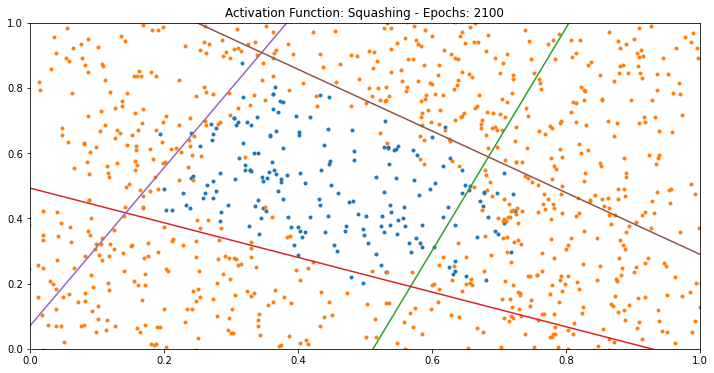

Epoch: 2200
G1-Weight: tensor([[ 8.8280, -2.6310]]) G1-Bias: tensor([-4.5045])
G2-Weight: tensor([[ 9.0837, 17.0391]]) G2-Bias: tensor([-8.4076])
G3-Weight: tensor([[15.2088, -6.2983]]) G1-Bias: tensor([0.4461])
G4-Weight: tensor([[-7.5839, -8.0128]]) G2-Bias: tensor([9.8976])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.828 * x + -4.5045) / -2.631)
z2: y = -((9.0837 * x + -8.4076) / 17.0391)
z3: y = -((15.2088 * x + 0.4461) / -6.2983)
z4: y = -((-7.5839 * x + 9.8976) / -8.0128)


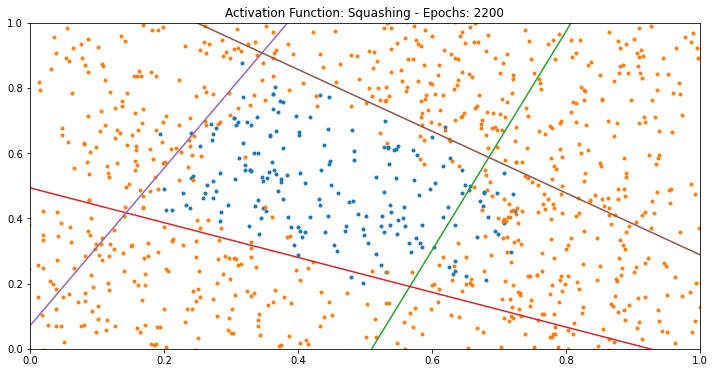

Epoch: 2300
G1-Weight: tensor([[ 8.7568, -2.6487]]) G1-Bias: tensor([-4.4486])
G2-Weight: tensor([[ 9.1325, 17.0720]]) G2-Bias: tensor([-8.4373])
G3-Weight: tensor([[15.5681, -6.4685]]) G1-Bias: tensor([0.4553])
G4-Weight: tensor([[-7.6311, -8.0544]]) G2-Bias: tensor([9.9543])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.7568 * x + -4.4486) / -2.6487)
z2: y = -((9.1325 * x + -8.4373) / 17.072)
z3: y = -((15.5681 * x + 0.4553) / -6.4685)
z4: y = -((-7.6311 * x + 9.9543) / -8.0544)


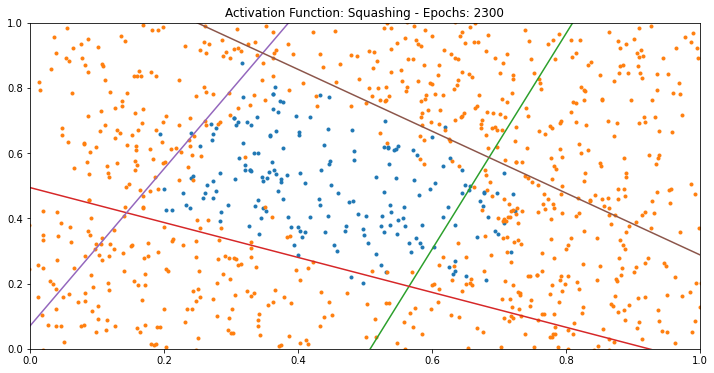

Epoch: 2400
G1-Weight: tensor([[ 8.6844, -2.6616]]) G1-Bias: tensor([-4.3949])
G2-Weight: tensor([[ 9.1805, 17.1071]]) G2-Bias: tensor([-8.4631])
G3-Weight: tensor([[15.9206, -6.6307]]) G1-Bias: tensor([0.4671])
G4-Weight: tensor([[-7.6717, -8.0892]]) G2-Bias: tensor([9.9960])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.6844 * x + -4.3949) / -2.6616)
z2: y = -((9.1805 * x + -8.4631) / 17.1071)
z3: y = -((15.9206 * x + 0.4671) / -6.6307)
z4: y = -((-7.6717 * x + 9.996) / -8.0892)


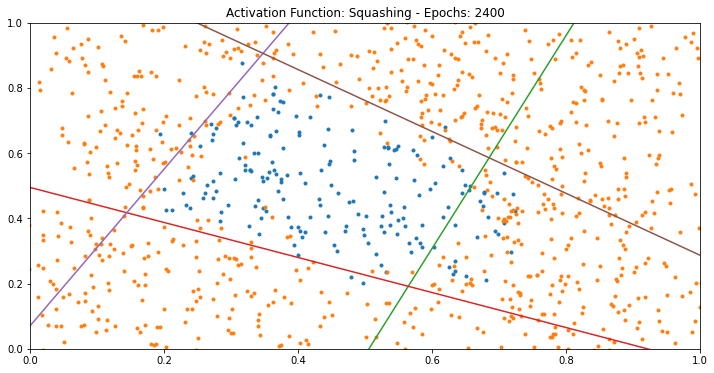

Epoch: 2500
G1-Weight: tensor([[ 8.6110, -2.6713]]) G1-Bias: tensor([-4.3415])
G2-Weight: tensor([[ 9.2266, 17.1440]]) G2-Bias: tensor([-8.4910])
G3-Weight: tensor([[16.2684, -6.7904]]) G1-Bias: tensor([0.4783])
G4-Weight: tensor([[-7.7013, -8.1134]]) G2-Bias: tensor([10.0270])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.611 * x + -4.3415) / -2.6713)
z2: y = -((9.2266 * x + -8.491) / 17.144)
z3: y = -((16.2684 * x + 0.4783) / -6.7904)
z4: y = -((-7.7013 * x + 10.027) / -8.1134)


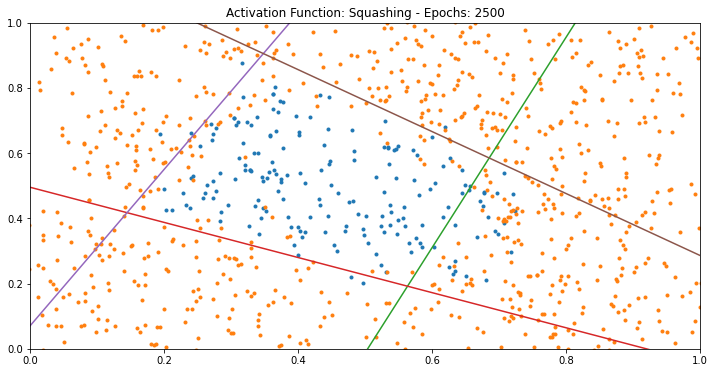

Epoch: 2600
G1-Weight: tensor([[ 8.5349, -2.6787]]) G1-Bias: tensor([-4.2892])
G2-Weight: tensor([[ 9.2729, 17.1840]]) G2-Bias: tensor([-8.5188])
G3-Weight: tensor([[16.6081, -6.9471]]) G1-Bias: tensor([0.4860])
G4-Weight: tensor([[-7.7218, -8.1294]]) G2-Bias: tensor([10.0493])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.5349 * x + -4.2892) / -2.6787)
z2: y = -((9.2729 * x + -8.5188) / 17.184)
z3: y = -((16.6081 * x + 0.486) / -6.9471)
z4: y = -((-7.7218 * x + 10.0493) / -8.1294)


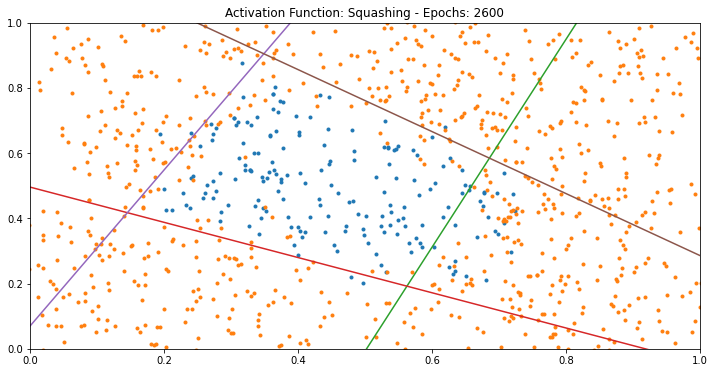

Epoch: 2700
G1-Weight: tensor([[ 8.4582, -2.6817]]) G1-Bias: tensor([-4.2357])
G2-Weight: tensor([[ 9.3157, 17.2231]]) G2-Bias: tensor([-8.5479])
G3-Weight: tensor([[16.9431, -7.1015]]) G1-Bias: tensor([0.4933])
G4-Weight: tensor([[-7.7353, -8.1389]]) G2-Bias: tensor([10.0619])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.4582 * x + -4.2357) / -2.6817)
z2: y = -((9.3157 * x + -8.5479) / 17.2231)
z3: y = -((16.9431 * x + 0.4933) / -7.1015)
z4: y = -((-7.7353 * x + 10.0619) / -8.1389)


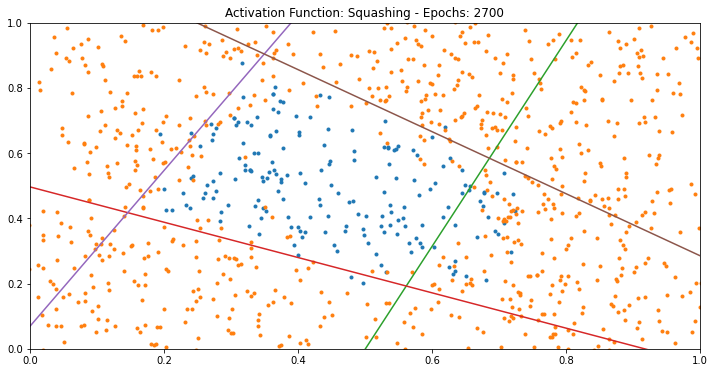

Epoch: 2800
G1-Weight: tensor([[ 8.3793, -2.6813]]) G1-Bias: tensor([-4.1820])
G2-Weight: tensor([[ 9.3584, 17.2634]]) G2-Bias: tensor([-8.5746])
G3-Weight: tensor([[17.2737, -7.2496]]) G1-Bias: tensor([0.5031])
G4-Weight: tensor([[-7.7418, -8.1406]]) G2-Bias: tensor([10.0648])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.3793 * x + -4.182) / -2.6813)
z2: y = -((9.3584 * x + -8.5746) / 17.2634)
z3: y = -((17.2737 * x + 0.5031) / -7.2496)
z4: y = -((-7.7418 * x + 10.0648) / -8.1406)


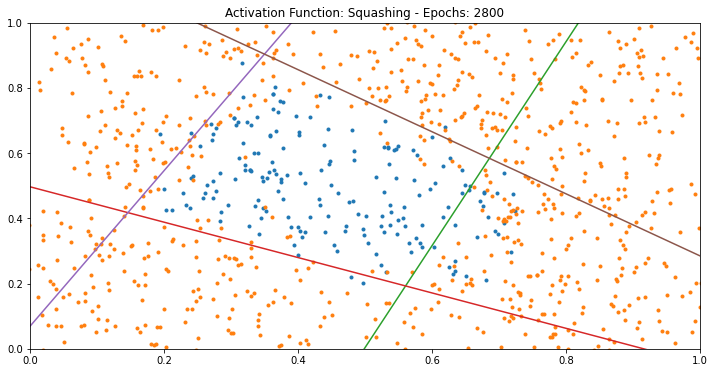

Epoch: 2900
G1-Weight: tensor([[ 8.2961, -2.6811]]) G1-Bias: tensor([-4.1303])
G2-Weight: tensor([[ 9.3974, 17.3031]]) G2-Bias: tensor([-8.6054])
G3-Weight: tensor([[17.5990, -7.3975]]) G1-Bias: tensor([0.5094])
G4-Weight: tensor([[-7.7409, -8.1359]]) G2-Bias: tensor([10.0618])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.2961 * x + -4.1303) / -2.6811)
z2: y = -((9.3974 * x + -8.6054) / 17.3031)
z3: y = -((17.599 * x + 0.5094) / -7.3975)
z4: y = -((-7.7409 * x + 10.0618) / -8.1359)


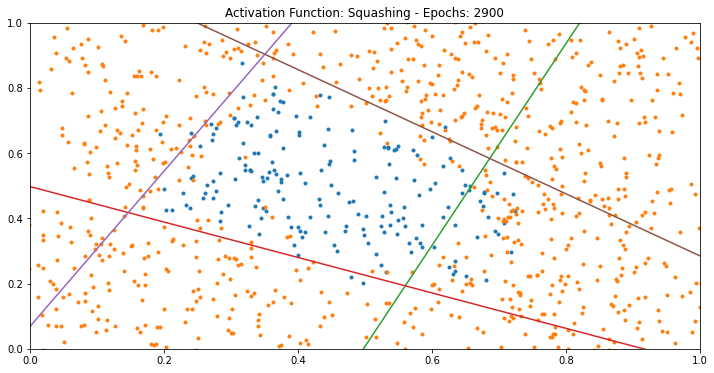

Epoch: 3000
G1-Weight: tensor([[ 8.2138, -2.6773]]) G1-Bias: tensor([-4.0741])
G2-Weight: tensor([[ 9.4420, 17.3484]]) G2-Bias: tensor([-8.6319])
G3-Weight: tensor([[17.9201, -7.5429]]) G1-Bias: tensor([0.5153])
G4-Weight: tensor([[-7.7322, -8.1244]]) G2-Bias: tensor([10.0475])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.2138 * x + -4.0741) / -2.6773)
z2: y = -((9.442 * x + -8.6319) / 17.3484)
z3: y = -((17.9201 * x + 0.5153) / -7.5429)
z4: y = -((-7.7322 * x + 10.0475) / -8.1244)


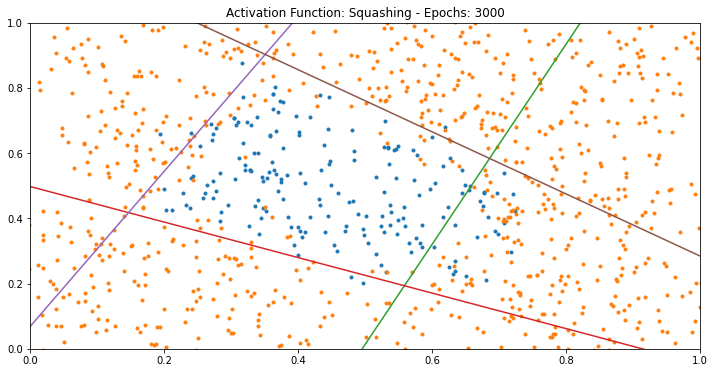

Epoch: 3100
G1-Weight: tensor([[ 8.1282, -2.6691]]) G1-Bias: tensor([-4.0202])
G2-Weight: tensor([[ 9.4831, 17.3931]]) G2-Bias: tensor([-8.6611])
G3-Weight: tensor([[18.2375, -7.6844]]) G1-Bias: tensor([0.5238])
G4-Weight: tensor([[-7.7215, -8.1090]]) G2-Bias: tensor([10.0316])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.1282 * x + -4.0202) / -2.6691)
z2: y = -((9.4831 * x + -8.6611) / 17.3931)
z3: y = -((18.2375 * x + 0.5238) / -7.6844)
z4: y = -((-7.7215 * x + 10.0316) / -8.109)


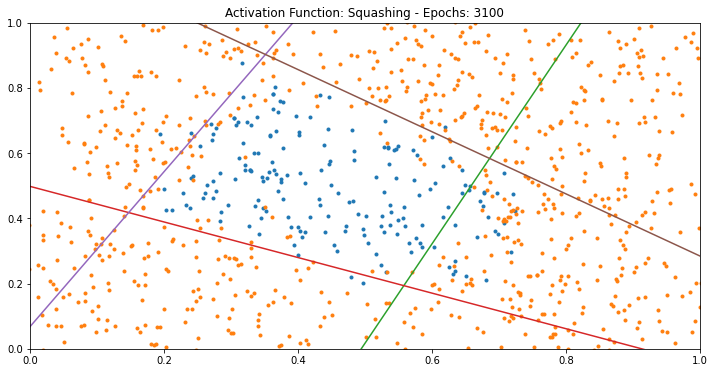

Epoch: 3200
G1-Weight: tensor([[ 8.0413, -2.6624]]) G1-Bias: tensor([-3.9636])
G2-Weight: tensor([[ 9.5234, 17.4374]]) G2-Bias: tensor([-8.6890])
G3-Weight: tensor([[18.5533, -7.8247]]) G1-Bias: tensor([0.5302])
G4-Weight: tensor([[-7.7003, -8.0838]]) G2-Bias: tensor([10.0028])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((8.0413 * x + -3.9636) / -2.6624)
z2: y = -((9.5234 * x + -8.689) / 17.4374)
z3: y = -((18.5533 * x + 0.5302) / -7.8247)
z4: y = -((-7.7003 * x + 10.0028) / -8.0838)


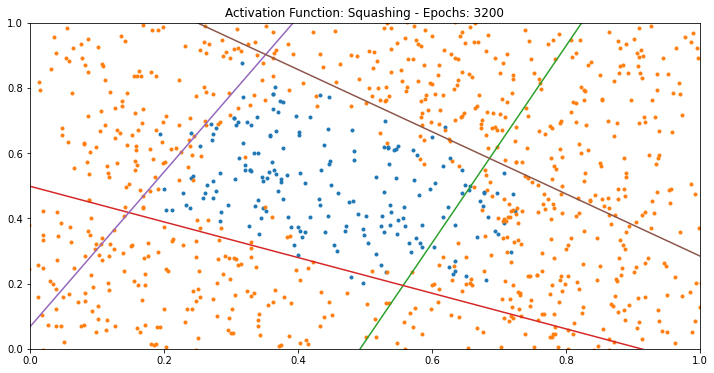

Epoch: 3300
G1-Weight: tensor([[ 7.9528, -2.6546]]) G1-Bias: tensor([-3.9087])
G2-Weight: tensor([[ 9.5645, 17.4839]]) G2-Bias: tensor([-8.7192])
G3-Weight: tensor([[18.8641, -7.9662]]) G1-Bias: tensor([0.5329])
G4-Weight: tensor([[-7.6758, -8.0563]]) G2-Bias: tensor([9.9721])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.9528 * x + -3.9087) / -2.6546)
z2: y = -((9.5645 * x + -8.7192) / 17.4839)
z3: y = -((18.8641 * x + 0.5329) / -7.9662)
z4: y = -((-7.6758 * x + 9.9721) / -8.0563)


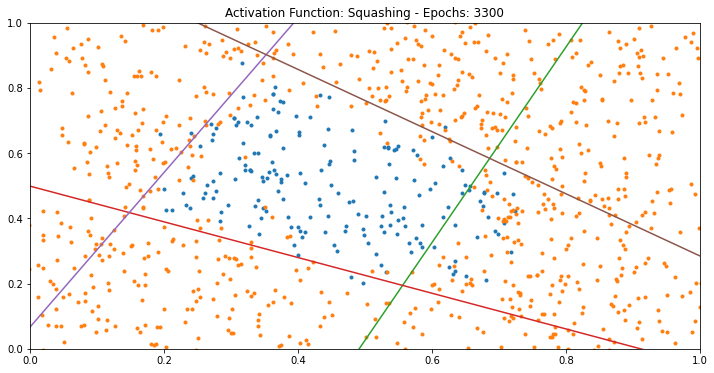

Epoch: 3400
G1-Weight: tensor([[ 7.8663, -2.6446]]) G1-Bias: tensor([-3.8530])
G2-Weight: tensor([[ 9.6057, 17.5316]]) G2-Bias: tensor([-8.7476])
G3-Weight: tensor([[19.1744, -8.1013]]) G1-Bias: tensor([0.5405])
G4-Weight: tensor([[-7.6477, -8.0246]]) G2-Bias: tensor([9.9349])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.8663 * x + -3.853) / -2.6446)
z2: y = -((9.6057 * x + -8.7476) / 17.5316)
z3: y = -((19.1744 * x + 0.5405) / -8.1013)
z4: y = -((-7.6477 * x + 9.9349) / -8.0246)


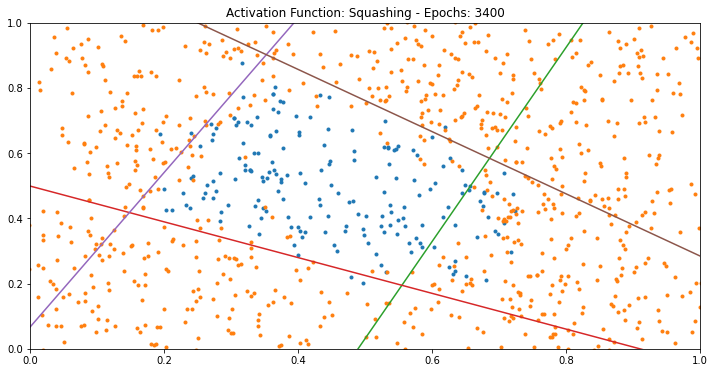

Epoch: 3500
G1-Weight: tensor([[ 7.7782, -2.6354]]) G1-Bias: tensor([-3.7963])
G2-Weight: tensor([[ 9.6469, 17.5795]]) G2-Bias: tensor([-8.7757])
G3-Weight: tensor([[19.4797, -8.2329]]) G1-Bias: tensor([0.5453])
G4-Weight: tensor([[-7.6166, -7.9899]]) G2-Bias: tensor([9.8944])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.7782 * x + -3.7963) / -2.6354)
z2: y = -((9.6469 * x + -8.7757) / 17.5795)
z3: y = -((19.4797 * x + 0.5453) / -8.2329)
z4: y = -((-7.6166 * x + 9.8944) / -7.9899)


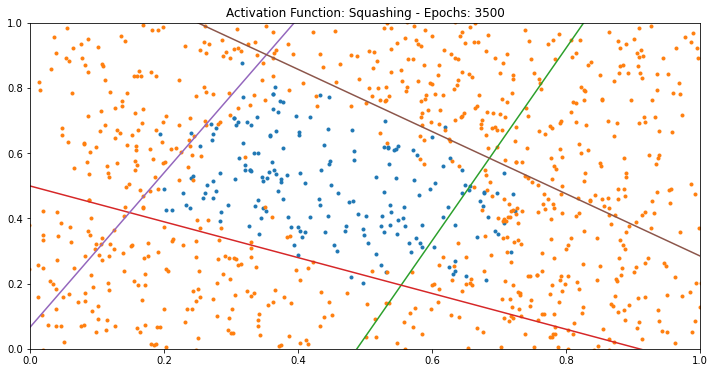

Epoch: 3600
G1-Weight: tensor([[ 7.6880, -2.6280]]) G1-Bias: tensor([-3.7426])
G2-Weight: tensor([[ 9.6871, 17.6282]]) G2-Bias: tensor([-8.8064])
G3-Weight: tensor([[19.7840, -8.3683]]) G1-Bias: tensor([0.5472])
G4-Weight: tensor([[-7.5835, -7.9540]]) G2-Bias: tensor([9.8575])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.688 * x + -3.7426) / -2.628)
z2: y = -((9.6871 * x + -8.8064) / 17.6282)
z3: y = -((19.784 * x + 0.5472) / -8.3683)
z4: y = -((-7.5835 * x + 9.8575) / -7.954)


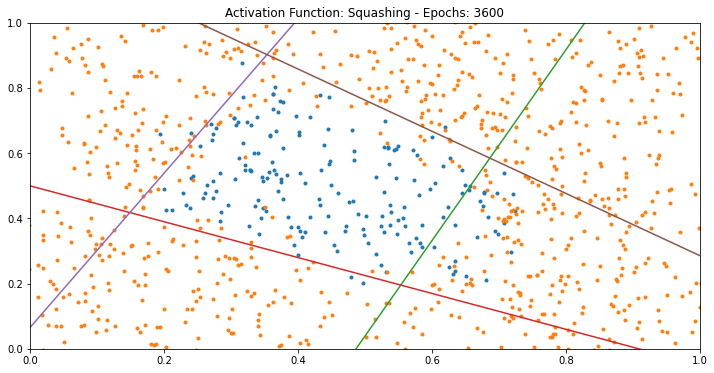

Epoch: 3700
G1-Weight: tensor([[ 7.6010, -2.6168]]) G1-Bias: tensor([-3.6870])
G2-Weight: tensor([[ 9.7260, 17.6755]]) G2-Bias: tensor([-8.8384])
G3-Weight: tensor([[20.0892, -8.4975]]) G1-Bias: tensor([0.5548])
G4-Weight: tensor([[-7.5543, -7.9228]]) G2-Bias: tensor([9.8167])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.601 * x + -3.687) / -2.6168)
z2: y = -((9.726 * x + -8.8384) / 17.6755)
z3: y = -((20.0892 * x + 0.5548) / -8.4975)
z4: y = -((-7.5543 * x + 9.8167) / -7.9228)


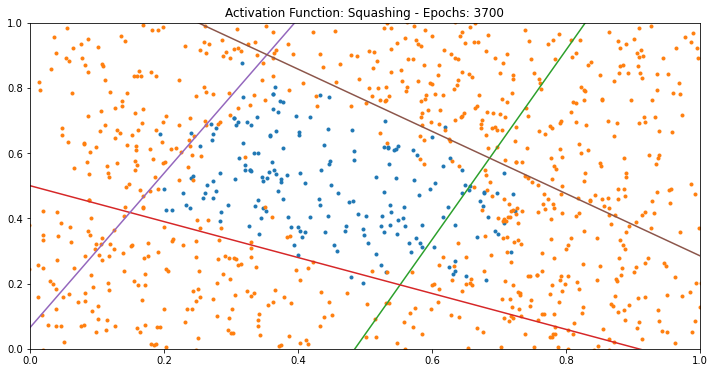

Epoch: 3800
G1-Weight: tensor([[ 7.5148, -2.6047]]) G1-Bias: tensor([-3.6319])
G2-Weight: tensor([[ 9.7669, 17.7258]]) G2-Bias: tensor([-8.8664])
G3-Weight: tensor([[20.3892, -8.6319]]) G1-Bias: tensor([0.5550])
G4-Weight: tensor([[-7.5247, -7.8899]]) G2-Bias: tensor([9.7803])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.5148 * x + -3.6319) / -2.6047)
z2: y = -((9.7669 * x + -8.8664) / 17.7258)
z3: y = -((20.3892 * x + 0.555) / -8.6319)
z4: y = -((-7.5247 * x + 9.7803) / -7.8899)


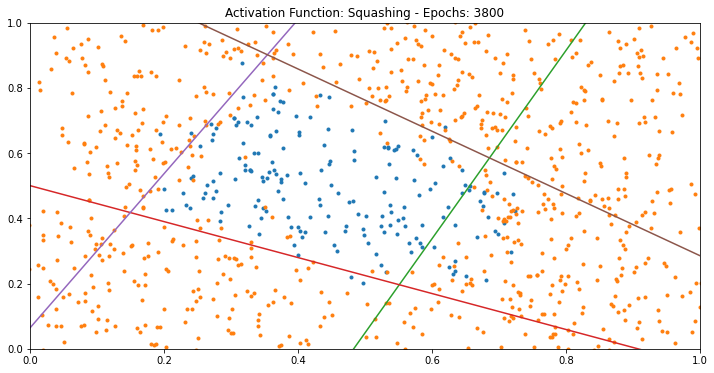

Epoch: 3900
G1-Weight: tensor([[ 7.4266, -2.5950]]) G1-Bias: tensor([-3.5800])
G2-Weight: tensor([[ 9.8061, 17.7760]]) G2-Bias: tensor([-8.9003])
G3-Weight: tensor([[20.6905, -8.7618]]) G1-Bias: tensor([0.5601])
G4-Weight: tensor([[-7.4957, -7.8587]]) G2-Bias: tensor([9.7437])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.4266 * x + -3.58) / -2.595)
z2: y = -((9.8061 * x + -8.9003) / 17.776)
z3: y = -((20.6905 * x + 0.5601) / -8.7618)
z4: y = -((-7.4957 * x + 9.7437) / -7.8587)


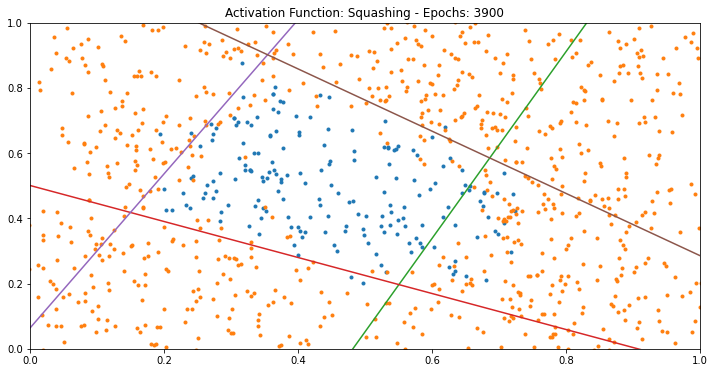

Epoch: 4000
G1-Weight: tensor([[ 7.3432, -2.5818]]) G1-Bias: tensor([-3.5270])
G2-Weight: tensor([[ 9.8454, 17.8260]]) G2-Bias: tensor([-8.9311])
G3-Weight: tensor([[20.9917, -8.8966]]) G1-Bias: tensor([0.5621])
G4-Weight: tensor([[-7.4679, -7.8277]]) G2-Bias: tensor([9.7098])
AND-Weight GOut: tensor([[1., 1., 1., 1.]]) AND-Bias: tensor([-3.])
z1: y = -((7.3432 * x + -3.527) / -2.5818)
z2: y = -((9.8454 * x + -8.9311) / 17.826)
z3: y = -((20.9917 * x + 0.5621) / -8.8966)
z4: y = -((-7.4679 * x + 9.7098) / -7.8277)


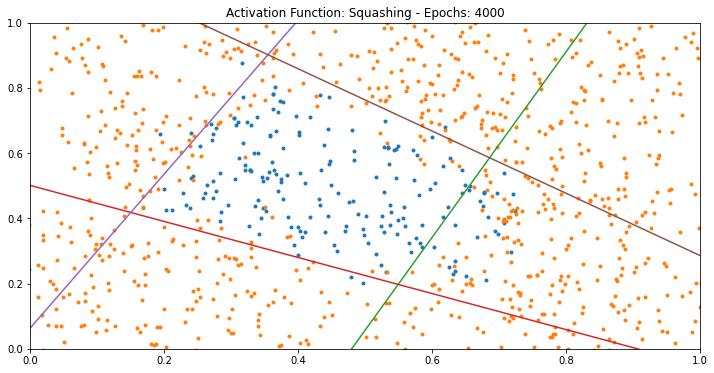

In [8]:
network = Net4(activation='squashing')

optimizer = optim.Adam(network.parameters(), lr=0.0233)
criterion = nn.MSELoss()

x = torch.linspace(-3, 3)

beta_g1_arr = []
beta_g2_arr = []
beta_g3_arr = []
beta_g4_arr = []

beta_and_arr = []
loss_arr = []
running_loss = 0

for epoch in range(4001):
    preds = network(trainX)
    #print(preds)
    loss = criterion(preds, trainY) # Calculate loss
    optimizer.zero_grad()
    loss.backward() # Calculate Gradient
    optimizer.step() # Update Weights

    beta_g1_arr.append(beta_g1)
    beta_g2_arr.append(beta_g2)
    beta_g3_arr.append(beta_g3)
    beta_g4_arr.append(beta_g4)

    beta_and_arr.append(beta_and)
    loss_arr.append(loss.item())
    running_loss += loss.item()

    if epoch %100 == 0:
        print("Epoch:", epoch)
        print("G1-Weight:", network.g1_layer.weight.data, "G1-Bias:", network.g1_layer.bias.data)
        print("G2-Weight:", network.g2_layer.weight.data, "G2-Bias:", network.g2_layer.bias.data)
        print("G3-Weight:", network.g3_layer.weight.data, "G1-Bias:", network.g3_layer.bias.data)
        print("G4-Weight:", network.g4_layer.weight.data, "G2-Bias:", network.g4_layer.bias.data)

        #print("AND-Weight G1G2:", network.undg1g2.weight.data, "AND-Bias:", network.undg1g2.bias.data)
        #print("AND-Weight G3G4:", network.undg3g4.weight.data, "AND-Bias:", network.undg3g4.bias.data)
        print("AND-Weight GOut:", network.undgout.weight.data, "AND-Bias:", network.undgout.bias.data)

        y1 = -((network.g1_layer.weight.squeeze()[0] * x + network.g1_layer.bias[0]) / network.g1_layer.weight.squeeze()[1])
        y2 = -((network.g2_layer.weight.squeeze()[0] * x + network.g2_layer.bias[0]) / network.g2_layer.weight.squeeze()[1])
        y3 = -((network.g3_layer.weight.squeeze()[0] * x + network.g3_layer.bias[0]) / network.g3_layer.weight.squeeze()[1])
        y4 = -((network.g4_layer.weight.squeeze()[0] * x + network.g4_layer.bias[0]) / network.g4_layer.weight.squeeze()[1])
        print(f'z1: y = -(({round(float(network.g1_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g1_layer.bias[0]),4)}) / {round(float(network.g1_layer.weight.squeeze()[1]), 4)})')
        print(f'z2: y = -(({round(float(network.g2_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g2_layer.bias[0]),4)}) / {round(float(network.g2_layer.weight.squeeze()[1]), 4)})')
        print(f'z3: y = -(({round(float(network.g3_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g3_layer.bias[0]),4)}) / {round(float(network.g3_layer.weight.squeeze()[1]), 4)})')
        print(f'z4: y = -(({round(float(network.g4_layer.weight.squeeze()[0]), 4)} * x + {round(float(network.g4_layer.bias[0]),4)}) / {round(float(network.g4_layer.weight.squeeze()[1]), 4)})')
        
        plt.figure(figsize=(12,6))
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

        plt.plot(x.numpy(), y1.detach().numpy(), '-')
        plt.plot(x.numpy(), y2.detach().numpy(), '-')
        plt.plot(x.numpy(), y3.detach().numpy(), '-')
        plt.plot(x.numpy(), y4.detach().numpy(), '-')
        #plt.title(f'Epoch: {epoch}; Learning Rate: 0.02\n β Linear Layer: {round(betagerade,4)} ; β AND Operator: {round(betaand,4)}')
        plt.title(f'Activation Function: Squashing - Epochs: {epoch}')
        #print("Beta:", betas)
        #print("Beta-Gerade:", betagerade)
        #print("Beta-AND:", betaand)
        #print("Loss:", running_loss/1000)
        plt.ylim(0,1)
        plt.xlim(0,1)
    plt.show()

<function matplotlib.pyplot.show>

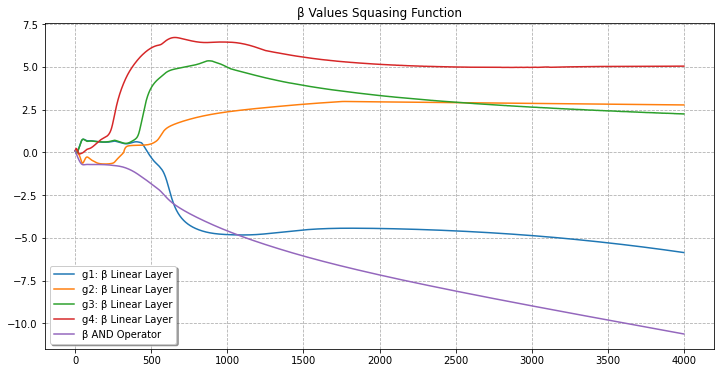

In [13]:
plt.figure(figsize=(12,6))
plt.plot(beta_g1_arr, label='g1: β Linear Layer')
plt.plot(beta_g2_arr, label='g2: β Linear Layer')
plt.plot(beta_g3_arr, label='g3: β Linear Layer')
plt.plot(beta_g4_arr, label='g4: β Linear Layer')

plt.plot(beta_and_arr, label='β AND Operator')
plt.legend(loc=2)
plt.grid(True, axis='both', linestyle='--')
plt.title('β Values Squasing Function')
plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True)
plt.show

<function matplotlib.pyplot.show>

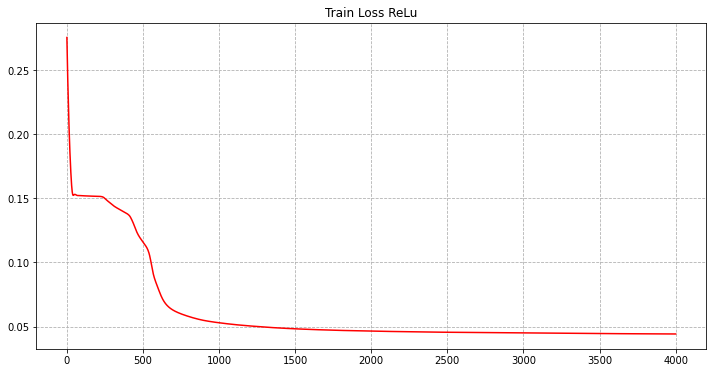

In [10]:
plt.figure(figsize=(12,6))
plt.title('Train Loss ReLu')
plt.plot(loss_arr, label='Loss', color='r')
plt.grid(True, axis='both', linestyle='--')
plt.show